# Uploading dataset

In [1]:
import itertools
import time
from typing import Any, Iterable, Mapping, Optional, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from IPython.display import display
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import NotFittedError
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    RandomizedSearchCV,
    TimeSeriesSplit,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor

# Constants
RANDOM_STATE = 12345
RMSE_THRESHOLD = 48
TRAIN_SET_SHARE = 0.9
TEST_SET_SHARE = 0.1
CV_FOLDS = 5
N_ITER = 14
SCORER = "neg_root_mean_squared_error"

# Setting visuals
sns.set_theme()

We have time series data so we should specify a column with dates as index of the DataFrame, which we will also have to sort in order to be time-consistent.

In [2]:
taxi_data = pd.read_csv("datasets/taxi.csv", parse_dates=[0], index_col=[0])

taxi_data.sort_index(inplace=True)

taxi_data.index.is_monotonic == True

True

In [3]:
display(taxi_data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
display(taxi_data.tail())

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


For forecasting we will actually need to resample the data by one hour.

In [5]:
periodicity = "1H"
taxi_data_resampled = taxi_data.resample(periodicity).sum()

display(taxi_data_resampled.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Summary**

This initial section enables us to set up all necessary libraries and load the data, which has been correctly saved in the DataFrame and resampled by 1 hour.

# Data analysis

In [6]:
taxi_data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


There seem to be no missing values in the DataFrame containing only one `num_orders` column (number of taxi orders). Additionally, we can see data correctly resampled by hour and having `DatetimeIndex`. Now, let's look at how numbers of orders are distributed.

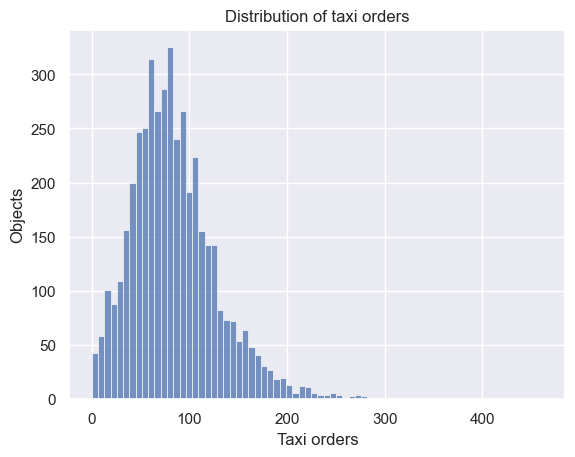

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.42,45.02,0.0,54.0,78.0,107.0,462.0


In [7]:
histogram = sns.histplot(data=taxi_data_resampled, x="num_orders")
histogram.set(
    title="Distribution of taxi orders",
    xlabel="Taxi orders",
    ylabel="Objects",
)
plt.show()

display(taxi_data_resampled.describe().round(2).T)

We can also visualize the data in a slightly different way - as a time series. For that, we will write a function called `plot_time_series()` that will display time series graph of the data for specific time period with a possibility to decompose time series and plot its components.

In [8]:
def plot_time_series(
    data: pd.DataFrame,
    col: str,
    period_start: str,
    period_end: str,
    kind: Optional[str] = None,
) -> Any:
    """Plots time series.

    When specifying kind="decomposed", conducts seasonal decomposition
    of the data and outputs graphs of trend, seasonal and residual
    components.

    Args:
        data (pd.DataFrame): DataFrame with information
            about taxi orders.
        col (str): DataFrame column containing
            data about taxi orders.
        period_start (str): Time period start.
        period_end (str): Time period end.
        kind (Optional[str], optional): Boolean indicator
            of performing time-series decomposition.
    """
    # Plotting decomposed time series
    if kind == "decomposed":
        decomposed = seasonal_decompose(data)

        plt.figure(figsize=(8, 10))

        # Trend component
        plt.subplot(311)
        trend_plot = sns.lineplot(
            data=decomposed.trend[period_start:period_end], ax=plt.gca()
        )
        trend_plot.set(title="Trend", xlabel="Time period", ylabel="Orders")
        plt.xticks(rotation=45)

        # Seasonal component
        plt.subplot(312)
        seasonal_plot = sns.lineplot(
            data=decomposed.seasonal[period_start:period_end], ax=plt.gca()
        )
        seasonal_plot.set(title="Seasonality", xlabel="Time period", ylabel="Orders")
        plt.xticks(rotation=45)

        # Residual component
        plt.subplot(313)
        residual_plot = sns.lineplot(
            data=decomposed.resid[period_start:period_end], ax=plt.gca()
        )
        residual_plot.set(title="Residual", xlabel="Time period", ylabel="Orders")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        return

    # Plotting time series
    full_data_plot = sns.lineplot(
        data=data[period_start:period_end],
        y=col,
        x=data[period_start:period_end].index,
        ax=plt.gca(),
    )
    full_data_plot.set(
        title="Taxi orders number", xlabel="Time period", ylabel="Orders"
    )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

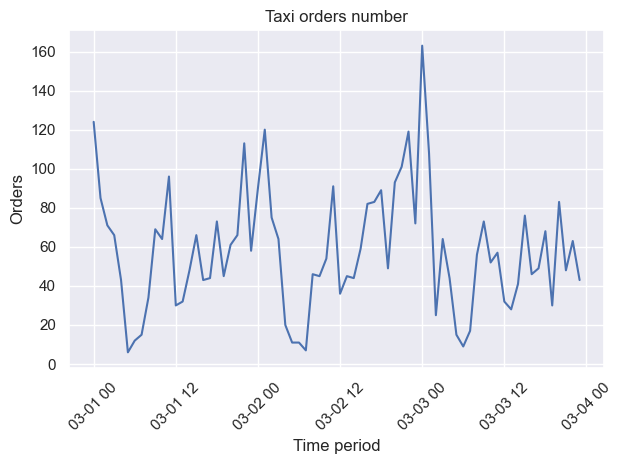

In [9]:
plot_time_series(
    data=taxi_data_resampled,
    col="num_orders",
    period_start="2018-03-01",
    period_end="2018-03-03",
)

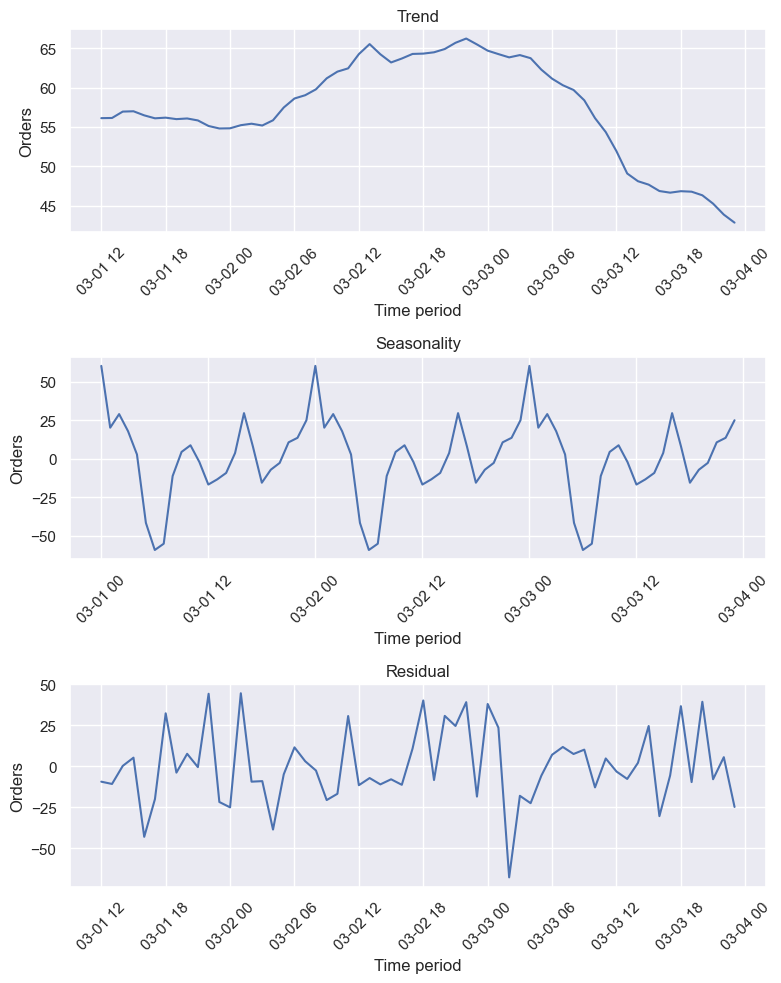

In [10]:
plot_time_series(
    data=taxi_data_resampled,
    col="num_orders",
    period_start="2018-03-01",
    period_end="2018-03-03",
    kind="decomposed",
)

We see here that there is a certain periodicity in taxi orders: every day at about 6 o'clock in the morning, orders reach their minimum and then grow, fluctuating, until reaching their maximum at midnight, after which the pattern repeats again. This fact makes us think about the possibility of the value of hours having an impact on the number of orders.

**Summary**

This stage was devoted to data visualization, where we were able to decompose the time series into three components: trend, seasonality and residual. The function we have written enabled us to visualize any period of time within the time series period as well as display the results of the seasonal decomposition of the series.

# Data preparation

## Features extraction

Now let's move on to data preparation. To begin with, we need to actually create a dataset so that it can then be passed on to machine learning algorithms, because we have only one column, which is also a target feature. What we can do is create time variables from the DataFrame index itself, and also introduce lag values of the target attribute and a moving average as features. For that, we will write a class `FeaturesExtractor` which will inherit from `sklearn.base.BaseEstimator` and `sklearn.base.TransformerMixin`.

In [11]:
class FeaturesExtractor(BaseEstimator, TransformerMixin):
    """Implements feature engineering for time series DataFrame."""

    def __init__(
        self,
        max_lag: int = 1,
        rolling_mean_order: int = 1,
    ) -> None:
        """Constructor for FeaturesExtractor class."""
        self.max_lag = max_lag
        self.rolling_mean_order = rolling_mean_order

    def fit(self, x: pd.DataFrame, y=None) -> None:
        """Returns the object itself."""
        return self

    def transform(self, x: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Extracts features from DateTimeIndex in accordance
        with arguments passed to `__init__`.
        """
        X = x.copy()
        # Adding time variables
        X["quarter"] = X.index.quarter
        X["month"] = X.index.month
        X["day"] = X.index.day
        X["hour"] = X.index.hour
        # Adding lags
        for lag in range(1, self.max_lag + 1):
            X["lag_{}".format(lag)] = X["num_orders"].shift(lag)
        # Adding moving average
        X["rolling_mean_{}".format(self.rolling_mean_order)] = (
            X["num_orders"].shift().rolling(self.rolling_mean_order).mean()
        )

        return X

In [12]:
features_extractor = FeaturesExtractor()
features_extractor.get_params()

{'max_lag': 1, 'rolling_mean_order': 1}

So, we see that we have successfully created a class object and its parameters were initialized with their default values. 

Everything is fine, but the question arises about which parameters it would be better to set for the class object, because the final quality of the models will depend on this. We will proceed as follows: first, we will create a grid `dataset_size_setter` with all possible and reasonable values for class parameters.

In [13]:
dataset_size_setter = {
    "max_lag": np.arange(1, 5),
    "rolling_mean_order": np.arange(1, 5),
}
dataset_size_setter

{'max_lag': array([1, 2, 3, 4]), 'rolling_mean_order': array([1, 2, 3, 4])}

Now, we can actually convert this dictionary of arrays into a list of dictionaries with keys initialized by all possible combinations of parameter values.

In [14]:
keys, values = zip(*dataset_size_setter.items())
config_list = [dict(zip(keys, v)) for v in itertools.product(*values)]
config_num = len(config_list)
print(f"Number of model configurations: {config_num:,}")

Number of model configurations: 16


In [15]:
config_list

[{'max_lag': 1, 'rolling_mean_order': 1},
 {'max_lag': 1, 'rolling_mean_order': 2},
 {'max_lag': 1, 'rolling_mean_order': 3},
 {'max_lag': 1, 'rolling_mean_order': 4},
 {'max_lag': 2, 'rolling_mean_order': 1},
 {'max_lag': 2, 'rolling_mean_order': 2},
 {'max_lag': 2, 'rolling_mean_order': 3},
 {'max_lag': 2, 'rolling_mean_order': 4},
 {'max_lag': 3, 'rolling_mean_order': 1},
 {'max_lag': 3, 'rolling_mean_order': 2},
 {'max_lag': 3, 'rolling_mean_order': 3},
 {'max_lag': 3, 'rolling_mean_order': 4},
 {'max_lag': 4, 'rolling_mean_order': 1},
 {'max_lag': 4, 'rolling_mean_order': 2},
 {'max_lag': 4, 'rolling_mean_order': 3},
 {'max_lag': 4, 'rolling_mean_order': 4}]

Let's choose some configuration (number 7, for example) and create the dataset.

In [16]:
config_idx = 6
config_selected = config_list[config_idx]
config_selected

{'max_lag': 2, 'rolling_mean_order': 3}

In [17]:
features_extractor = features_extractor.set_params(**config_selected)
features_extractor.get_params()

{'max_lag': 2, 'rolling_mean_order': 3}

In [18]:
taxi_dataset = features_extractor.fit_transform(taxi_data_resampled)
taxi_dataset.head()

,num_orders,quarter,month,day,hour,lag_1,lag_2,rolling_mean_3
datetime,,,,,,,,
2018-03-01 00:00:00,124,1,3,1,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,1,3,1,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,1,3,1,3,71.0,85.0,93.333333
2018-03-01 04:00:00,43,1,3,1,4,66.0,71.0,74.000000


We can now see that all four time variables have been created in addition to two lagged columns of `num_orders` as well as moving average of order 3.

## Correlation matrix

Let's now plot correlation matrix heatmap using a function we will write.

In [19]:
def plot_corr_heatmap(
    data: pd.DataFrame,
    target_var: Optional[pd.Series] = None,
    annot_num_size: Optional[int] = None,
    heatmap_coloring: Optional[Any] = None,
    upper_triangle: bool = False,
    lower_triangle: bool = False,
) -> Any:
    """Plots a heatmap for the correlation matrix.

    Args:
        data (pd.DataFrame): DataFrame for which a heatmap needs
            to be plotted.
        target_var(Optional[pd.Series], optional): Target-vector
            which needs to be included in the heatmap. Defaults
            to None.
        annot_num_size (Optional[int], optional): Size of the
            figures inside the plot. Defaults to None.
        heatmap_coloring (Optional[Any], optional): Heatmap colormap.
            Defaults to None.
        upper_triangle (bool, optional): Boolean indicator of displaying
            only the upper triangle of the matrix. Defaults to False.
        lower_triangle (bool, optional): Boolean indicator of displaying
            only the lower triangle of the matrix. Defaults to False.
    """
    # Adding target variable to the data
    if target_var is not None:
        data = pd.concat([data, target_var], axis=1)

    # Computing correlation matrix
    corr_matrix = data.corr()

    # Showing upper/lower triangle of a matrix
    if upper_triangle:
        mask = np.zeros_like(corr_matrix)
        mask[np.tril_indices_from(mask)] = True
    elif lower_triangle:
        mask = np.zeros_like(corr_matrix)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None

    # Plotting a matrix
    corr_heatmap = sns.heatmap(
        corr_matrix,
        annot=True,
        mask=mask,
        annot_kws={"size": annot_num_size},
        cmap=heatmap_coloring,
    )
    corr_heatmap.xaxis.tick_bottom()
    corr_heatmap.yaxis.tick_left()
    corr_heatmap.set(title="Correlation matrix")
    plt.show()

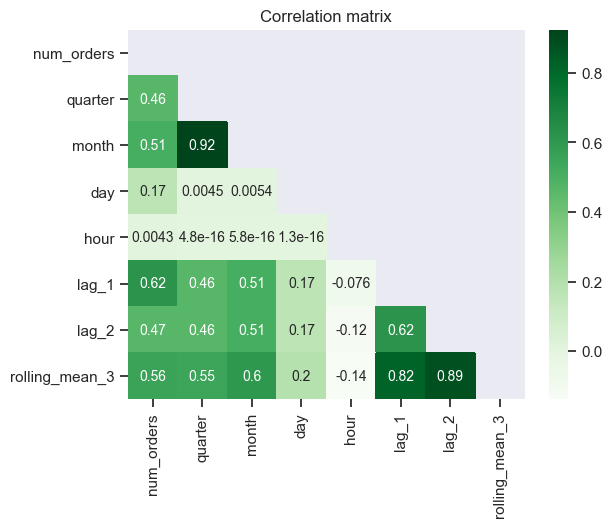

In [20]:
# Correlation matrix heatmap
plot_corr_heatmap(
    data=taxi_dataset, annot_num_size=10, heatmap_coloring="Greens", lower_triangle=True
)

The dataset has been successfully created and we see that many of the features are correlated with the target variable. Of course, `hour` column does not correlate well with the number of orders, but still the correlation does not imply causality, so we will leave it intact in the DataFrame and see later how important it will be for prediction.

## Data split

Lastly, let's separate the dataset into training and testing sets by a means of `prepare_ts()` function defined below.

In [21]:
TrainValidTest = Tuple[
    pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series
]
TrainTest = Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]

In [22]:
def prepare_ts(
    data: pd.DataFrame,
    target_name: str,
    train_share: float,
    test_share: float,
    valid_share: Optional[float] = None,
) -> Union[TrainValidTest, TrainTest]:
    """Conducts time series data split into sets.

    Depending on the value passed to `valid_share`,
    splits the data either into training, validation
    and test sets or into training and test sets.

    Args:
        data (pd.DataFrame): DataFrame which needs to be
            split into sets.
        target_name (str): Name of the target variable.
        train_share (float): Share of the training set.
        test_share (float): Share of the test set.
        valid_share (Optional[float], optional): Share of
            the validation set. Defaults to None.

    Returns:
        Union[TrainValidTest, TrainTest]: Tuple of training,
        validation and test sets or Tuple of training and
        test sets.
    """
    # Data split into train/validation/test
    if valid_share is not None:
        # Checking consistency of set shares
        if np.sum([train_share, valid_share, test_share]) != 1.0:
            raise ValueError("Incorrect sets proportions specified")

        split_1 = 1 - train_share
        split_2 = test_share / np.sum([valid_share, test_share])

        training_set, valid_test_set = train_test_split(
            data, shuffle=False, test_size=split_1
        )
        valid_set, test_set = train_test_split(
            valid_test_set, shuffle=False, test_size=split_2
        )

        # Dropping nans due to lags
        training_set = training_set.dropna()

        features_train = training_set.drop([target_name], axis=1)
        target_train = training_set[target_name]

        features_valid = valid_set.drop([target_name], axis=1)
        target_valid = valid_set[target_name]

        features_test = test_set.drop([target_name], axis=1)
        target_test = test_set[target_name]

        return (
            features_train,
            target_train,
            features_valid,
            target_valid,
            features_test,
            target_test,
        )

    # Data split into training/test
    if np.sum([train_share, test_share]) != 1.0:
        raise ValueError("Incorrect sets proportions specified")

    # Data split
    training_set, test_set = train_test_split(data, shuffle=False, test_size=test_share)

    # Dropping nans due to lags
    training_set = training_set.dropna()

    # Separating features from target
    features_train = training_set.drop([target_name], axis=1)
    target_train = training_set[target_name]

    features_test = test_set.drop([target_name], axis=1)
    target_test = test_set[target_name]

    return features_train, target_train, features_test, target_test

In [23]:
features_train, target_train, features_test, target_test = prepare_ts(
    data=taxi_dataset,
    target_name="num_orders",
    train_share=TRAIN_SET_SHARE,
    test_share=TEST_SET_SHARE,
)

In [24]:
features_train_share = np.round(features_train.shape[0] / taxi_dataset.shape[0], 2)
target_train_share = np.round(target_train.shape[0] / taxi_dataset.shape[0], 2)

features_test_share = np.round(features_test.shape[0] / taxi_dataset.shape[0], 2)
target_test_share = np.round(target_test.shape[0] / taxi_dataset.shape[0], 2)

assert features_train_share == target_train_share == TRAIN_SET_SHARE
assert features_test_share == target_test_share == TEST_SET_SHARE

**Summary**

At this stage, we were able to prepare data for machine learning algorithms. In particular, we were able to create a dataset by extracting features from the dataframe index and its data, and also divided the data into samples.

# Hyperparameter tuning

Now we move on to training models, which we will do by selecting hyperparameters. Consider the following regression models:

1. `DecisionTreeRegressor()`
2. `RandomForestRegressor()`
3. `CatBoostRegressor()`
4. `XGBRegressor()`
5. `LGBMRegressor()`

To select optimal combinations of hyperparameters, we will write a wrapper `HyperparamsOptimizer` for `GridSearchCV` with an opportunity to additionally generate hyperparameter tuning results in the DataFrame format.

In [25]:
RandomStateInstance = np.random.mtrand.RandomState

In [26]:
class RandomizedHyperoptRegression(RandomizedSearchCV):
    """
    Wrapper for RandomizedSearchCV with custom defaults
    and additional functionality for running regressions.
    """

    def __init__(
        self,
        estimator: BaseEstimator,
        param_distributions: Union[Sequence[Mapping], Mapping],
        train_dataset: Tuple[Any, Any],
        eval_dataset: Tuple[Any, Any],
        cv: Union[Iterable, int] = 2,
        random_state: Union[RandomStateInstance, int] = 12345,
        scoring: str = "neg_root_mean_squared_error",
        n_iter: int = 5,
        n_jobs: Optional[int] = None,
        return_train_score: bool = True,
    ) -> None:
        """Initializes an instance.

        Args:
            estimator (BaseEstimator): Sklearn model, Gradient Boosting model or
                Pipeline object.
            param_distributions (Union[Sequence[Mapping], Mapping]): Grid of
                hyperparameter names and their values to be varied.
            train_dataset (Tuple[Any, Any]): Tuple of training features and
                training target-vector.
            eval_dataset (Tuple[Any, Any]): Tuple of testing features and
                testing target-vector.
            cv (Union[Iterable, int], optional): Crossvalidator represented
                as an iterator or an integer. Defaults to 2.
            random_state (Union[RandomStateInstance, int], optional): Random seed
                represented as either RandomState instance or an integer.
                Defaults to 12345.
            scoring (str, optional): Scoring metric.
                Defaults to "neg_root_mean_squared_error".
            n_iter (int, optional): Number of hyperparameter combinations
                to consider. Defaults to 5.
            n_jobs (Optional[int], optional): Parallelization of computations.
                Defaults to None.
            return_train_score (bool, optional): Boolean indicating returning
                metric values scores computed on training set. Defaults to True.
        """
        super().__init__(
            estimator=estimator,
            param_distributions=param_distributions,
            cv=cv,
            random_state=random_state,
            scoring=scoring,
            n_iter=n_iter,
            n_jobs=n_jobs,
            return_train_score=return_train_score,
        )
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.train_features, self.train_target = self.train_dataset
        self.eval_features, self.eval_target = self.eval_dataset

    def train_crossvalidate(self) -> Any:
        """Launching grid search algorithm."""
        # Computing grid search time
        start = time.time()
        self.fit(self.train_features, self.train_target)
        end = time.time() - start

        # Choosing the appropriate name of the last estimator
        try:
            model_name = type(
                self.estimator.named_steps[(*self.estimator.named_steps,)[1]]
            ).__name__
        except:
            model_name = type(self.best_estimator_).__name__

        print(f"Grid search for {model_name} completed.")
        print(f"Time elasped:{end: .1f} s")

    def display_tuning_process(self, best_iter: bool = False) -> pd.DataFrame:
        """
        Displaying the results of grid search. Additionally, displays the
        best combination of hyperparameters and scoring metric values.
        """
        # Verifying if the grid search has been lauched
        try:
            cv_results_df = pd.DataFrame(self.cv_results_)
        except AttributeError:
            not_fitted_error_msg = (
                f"The {type(self).__name__} instance has not been fitted yet.\n"
                "Call 'train_crossvalidate' before using this method."
            )
            print(not_fitted_error_msg)
        else:
            if self.return_train_score:
                # Selecting varied hyperparameters and train/test metric values
                relevant_columns = (
                    list(
                        cv_results_df.columns[
                            cv_results_df.columns.str.startswith("param_")
                        ]
                    )
                    + ["mean_train_score"]
                    + ["mean_test_score"]
                )
                cv_results_df = cv_results_df[relevant_columns]
                cv_results_df["mean_train_score"] = -cv_results_df["mean_train_score"]
            else:
                # Selecting varied hyperparameters and test metric values
                relevant_columns = list(
                    cv_results_df.columns[
                        cv_results_df.columns.str.startswith("param_")
                    ]
                ) + ["mean_test_score"]
                cv_results_df = cv_results_df[relevant_columns]

            cv_results_df["mean_test_score"] = -cv_results_df["mean_test_score"]

            # Fixing column names and precision
            try:
                last_estimator_name = (*self.best_estimator_.named_steps,)[1]
                col_name = "param_" + last_estimator_name + "__"
                cv_results_df.columns = cv_results_df.columns.str.replace(col_name, "")
            except AttributeError:
                cv_results_df.columns = cv_results_df.columns.str.replace("param_", "")

            cv_results_df = cv_results_df.round(4)

            if best_iter:
                # Displaying the best iteration
                try:
                    cv_results_df = cv_results_df.iloc[self.best_index_].rename(
                        type(self.best_estimator_["model"]).__name__
                    )
                except:
                    cv_results_df = cv_results_df.iloc[self.best_index_].rename(
                        type(self.best_estimator_).__name__
                    )

            return cv_results_df

    def compute_regression_stats(self, metric: str) -> Optional[float]:
        """Computes key regression metrics."""
        try:
            self.eval_predictions = self.predict(self.eval_features)
        except NotFittedError:
            not_fitted_error_msg = (
                f"The {type(self).__name__} instance has not been fitted yet.\n"
                "Call 'train_crossvalidate' before using this method."
            )
            print(not_fitted_error_msg)
        # Proceed if exception has not been activated
        else:
            if metric == "rmse":
                rmse = mean_squared_error(
                    self.eval_target, self.eval_predictions, squared=False
                )
                return rmse
            elif metric == "mse":
                mse = mean_squared_error(
                    self.eval_target, self.eval_predictions, squared=True
                )
                return mse
            elif metric == "mae":
                mae = mean_absolute_error(self.eval_target, self.eval_predictions)
                return mae
            else:
                raise ValueError("Incorrect metric name specified")

Since we deal with time series data, we will use an appropriate cross-validator.

In [27]:
tscv = TimeSeriesSplit(n_splits=CV_FOLDS, test_size=target_test.shape[0])

## Parameter grids

In [28]:
decision_tree_params_grid = {"max_depth": np.arange(1, 15)}

In [29]:
random_forest_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 70, 10),
}

In [30]:
catboost_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 70, 10),
}

In [31]:
xgboost_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 70, 10),
}

In [32]:
lgbm_params_grid = {
    "max_depth": np.arange(1, 7),
    "n_estimators": np.arange(10, 70, 10),
}

## Models

In [33]:
decision_tree_model = DecisionTreeRegressor(random_state=12345)

In [34]:
random_forest_model = RandomForestRegressor(random_state=12345)

In [35]:
catboost_model = CatBoostRegressor(verbose=0)

In [36]:
xgboost_model = XGBRegressor()

In [37]:
lgbm_model = LGBMRegressor()

## Selection

### `DecisionTree`

In [38]:
decision_tree_grid_search = RandomizedHyperoptRegression(
    estimator=decision_tree_model,
    param_distributions=decision_tree_params_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
    n_iter=N_ITER,
    cv=tscv,
    random_state=RANDOM_STATE,
    scoring=SCORER,
)
decision_tree_grid_search.train_crossvalidate()

Grid search for DecisionTreeRegressor completed.
Time elasped: 0.7 s


In [39]:
decision_tree_grid_search.display_tuning_process()

,max_depth,mean_train_score,mean_test_score
0,1,30.1159,38.8689
1,2,27.0543,36.5981
2,3,25.1506,34.5144
3,4,23.8868,33.4580
4,5,22.3387,31.7670
5,6,20.9436,31.0397
6,7,19.3465,30.8343
7,8,17.7602,31.3972
8,9,15.9921,31.3697
9,10,14.2560,32.2536


In [40]:
decision_tree_grid_search.display_tuning_process(best_iter=True)

max_depth                 7
mean_train_score    19.3465
mean_test_score     30.8343
Name: DecisionTreeRegressor, dtype: object

### `RandomForest`

In [41]:
random_forest_grid_search = RandomizedHyperoptRegression(
    estimator=random_forest_model,
    param_distributions=random_forest_params_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
    n_iter=N_ITER,
    cv=tscv,
    random_state=RANDOM_STATE,
    scoring=SCORER,
)
random_forest_grid_search.train_crossvalidate()

Grid search for RandomForestRegressor completed.
Time elasped: 5.9 s


In [42]:
random_forest_grid_search.display_tuning_process()

,n_estimators,max_depth,mean_train_score,mean_test_score
0,60,1,29.6087,38.6828
1,30,1,29.5781,38.7111
2,40,4,22.9363,32.2418
3,20,5,21.5913,30.5243
4,50,5,21.4595,30.4141
5,40,1,29.5960,38.6759
6,10,1,29.7292,38.7365
7,50,1,29.6121,38.7133
8,10,5,21.6767,30.7151
9,20,6,20.1381,29.3127


In [43]:
random_forest_grid_search.display_tuning_process(best_iter=True)

n_estimators             20
max_depth                 6
mean_train_score    20.1381
mean_test_score     29.3127
Name: RandomForestRegressor, dtype: object

### `Catboost`

In [44]:
catboost_grid_search = RandomizedHyperoptRegression(
    estimator=catboost_model,
    param_distributions=catboost_params_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
    n_iter=N_ITER,
    cv=tscv,
    random_state=RANDOM_STATE,
    scoring=SCORER,
)
catboost_grid_search.train_crossvalidate()

Grid search for CatBoostRegressor completed.
Time elasped: 6.3 s


In [45]:
catboost_grid_search.display_tuning_process()

,n_estimators,max_depth,mean_train_score,mean_test_score
0,60,1,22.2389,29.3180
1,30,1,23.2515,30.4490
2,40,4,17.9252,26.4651
3,20,5,18.7881,26.5099
4,50,5,16.3210,26.8390
5,40,1,22.8082,30.0239
6,10,1,25.5848,33.8353
7,50,1,22.4668,29.5421
8,10,5,20.6249,27.6673
9,20,6,18.0788,26.7969


In [46]:
catboost_grid_search.display_tuning_process(best_iter=True)

n_estimators             40
max_depth                 4
mean_train_score    17.9252
mean_test_score     26.4651
Name: CatBoostRegressor, dtype: object

### `XGBoost`

In [47]:
xgboost_grid_search = RandomizedHyperoptRegression(
    estimator=xgboost_model,
    param_distributions=xgboost_params_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
    n_iter=N_ITER,
    cv=tscv,
    random_state=RANDOM_STATE,
    scoring=SCORER,
)
xgboost_grid_search.train_crossvalidate()

Grid search for XGBRegressor completed.
Time elasped: 1.7 s


In [48]:
xgboost_grid_search.display_tuning_process()

,n_estimators,max_depth,mean_train_score,mean_test_score
0,60,1,22.6426,29.7273
1,30,1,23.6837,31.7712
2,40,4,15.9530,27.0962
3,20,5,15.8875,27.1484
4,50,5,12.5719,27.4848
5,40,1,23.1716,30.7445
6,10,1,26.7608,36.7633
7,50,1,22.8625,30.1623
8,10,5,18.1347,28.6351
9,20,6,13.9973,27.5620


In [49]:
xgboost_grid_search.display_tuning_process(best_iter=True)

n_estimators             40
max_depth                 3
mean_train_score    17.9501
mean_test_score     26.7804
Name: XGBRegressor, dtype: object

### `LGBM`

In [50]:
lgbm_grid_search = RandomizedHyperoptRegression(
    estimator=lgbm_model,
    param_distributions=lgbm_params_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
    n_iter=N_ITER,
    cv=tscv,
    random_state=RANDOM_STATE,
    scoring=SCORER,
)
lgbm_grid_search.train_crossvalidate()

Grid search for LGBMRegressor completed.
Time elasped: 1.1 s


In [51]:
lgbm_grid_search.display_tuning_process()

,n_estimators,max_depth,mean_train_score,mean_test_score
0,60,1,24.8435,33.5962
1,30,1,26.9121,36.0875
2,40,4,19.2357,27.6687
3,20,5,20.3311,29.4083
4,50,5,17.5863,26.6084
5,40,1,26.0529,35.1083
6,10,1,29.7285,39.7297
7,50,1,25.3763,34.3222
8,10,5,23.4221,33.0431
9,20,6,19.5103,28.7977


In [52]:
lgbm_grid_search.display_tuning_process(best_iter=True)

n_estimators             50
max_depth                 5
mean_train_score    17.5863
mean_test_score     26.6084
Name: LGBMRegressor, dtype: object

# Model analysis

In [53]:
def plot_model_comparison(
    results: Sequence[Tuple[str, float]],
    metric_name: str = "metric_name",
    title_name: str = "title_name",
    dot_size: int = 150,
    figure_dims: Tuple[int] = (15, 7),
    xticks_fontsize: int = 15,
    yticks_fontsize: int = 12,
    title_fontsize: int = 20,
    ylabel_fontsize: int = 15,
) -> Any:
    """Provides models performance vizualization.

    Generates a scatterplot with model names and their
    respective metric values for comparison.

    Args:
        results (Sequence[Tuple[str, float]]): Sequence of Tuples with
            model names and metric values.
        metric_name (str, optional): Name of the metric. Defaults to
            "metric_name".
        title_name (str, optional): Title of the plot. Defaults to
            "title_name".
        dot_size (int, optional): Size of scatterplot dots.
            Defaults to 150.
        figure_dims (Tuple[int], optional): Dimensions of the figure.
            Defaults to (15, 7).
        xticks_fontsize (int, optional): Size of xticks on the plot.
            Defaults to 15.
        yticks_fontsize (int, optional): Size of yticks on the plot.
            Defaults to 12.
        title_fontsize (int, optional): Size of the title of the plot.
            Defaults to 20.
        ylabel_fontsize (int, optional): Size of the Y-label.
            Defaults to 15.
    """
    # Separating scores from a sequence of tuples passed
    _, scores = zip(*results)
    # Joining model names with scores
    names_with_scores = ["%s\n%.4f" % (name, loss) for name, loss in results]

    # Making a plot
    plt.figure(figsize=figure_dims)

    plt.scatter(range(len(results)), scores, s=dot_size)

    plt.xticks(range(len(results)), names_with_scores, fontsize=xticks_fontsize)
    plt.yticks(fontsize=yticks_fontsize)

    plt.title(title_name, fontsize=title_fontsize)
    plt.ylabel(metric_name, fontsize=ylabel_fontsize)

    plt.tight_layout()

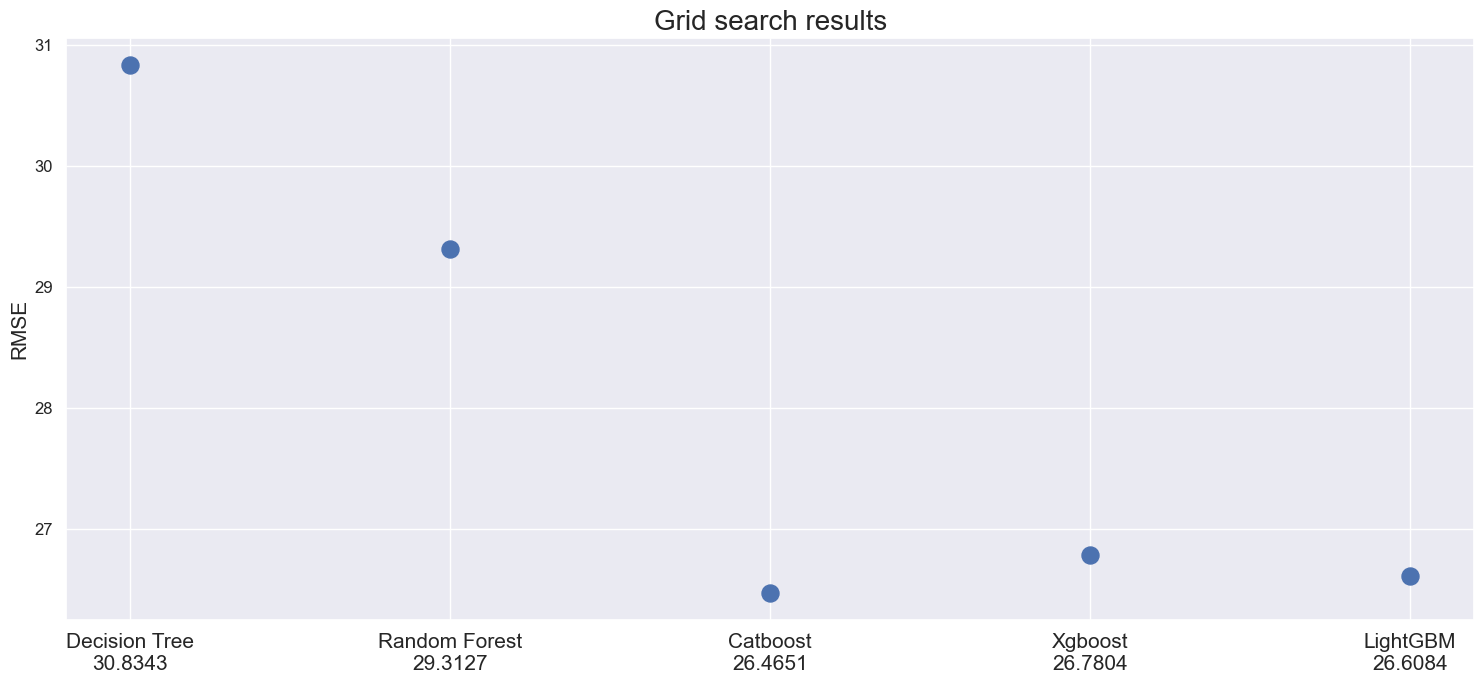

In [54]:
results = [
    ("Decision Tree", -decision_tree_grid_search.best_score_),
    ("Random Forest", -random_forest_grid_search.best_score_),
    ("Catboost", -catboost_grid_search.best_score_),
    ("Xgboost", -xgboost_grid_search.best_score_),
    ("LightGBM", -lgbm_grid_search.best_score_),
]
plot_model_comparison(
    results,
    metric_name="RMSE",
    title_name="Grid search results",
)

In [55]:
# Dynamically selecting the best model
grids = (
    decision_tree_grid_search,
    random_forest_grid_search,
    catboost_grid_search,
    xgboost_grid_search,
    lgbm_grid_search,
)

final_score = np.Inf
final_grid = None
for grid in grids:
    score = -grid.best_score_
    if score < final_score:
        final_score = score
        final_grid = grid

**Summary**

The results of hyperparameter tuning showed that it would be reasonable to select *Catboost* model.

# Testing

In [56]:
rmse_test = final_grid.compute_regression_stats(metric="rmse")

assert rmse_test < RMSE_THRESHOLD, "Model quality is insufficient"

print(f"Test score: {rmse_test:.4f}")

Test score: 46.5618


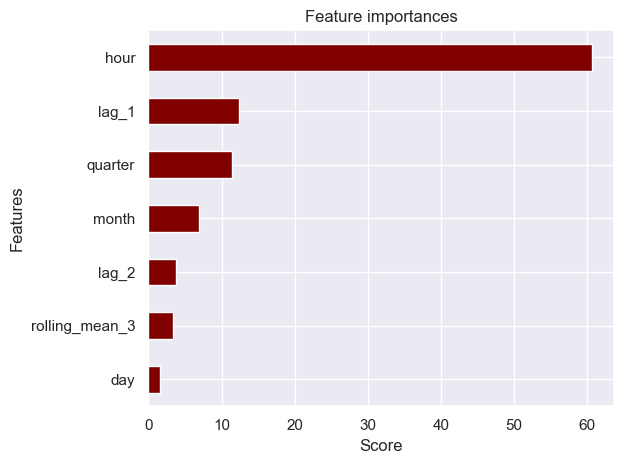

In [57]:
# Plotting feature importance
feature_importances = pd.Series(
    final_grid.best_estimator_.feature_importances_, index=features_train.columns
).sort_values()

feature_importances.plot(kind="barh", color="maroon")

plt.title("Feature importances")
plt.ylabel("Features")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

In [58]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_train, target_train)
predictions_dummy = dummy_model.predict(features_test)
rmse_dummy = mean_squared_error(predictions_dummy, target_test, squared=False)

assert rmse_test < rmse_dummy, "Model is inadequate"

print("Model is adequate")

Model is adequate


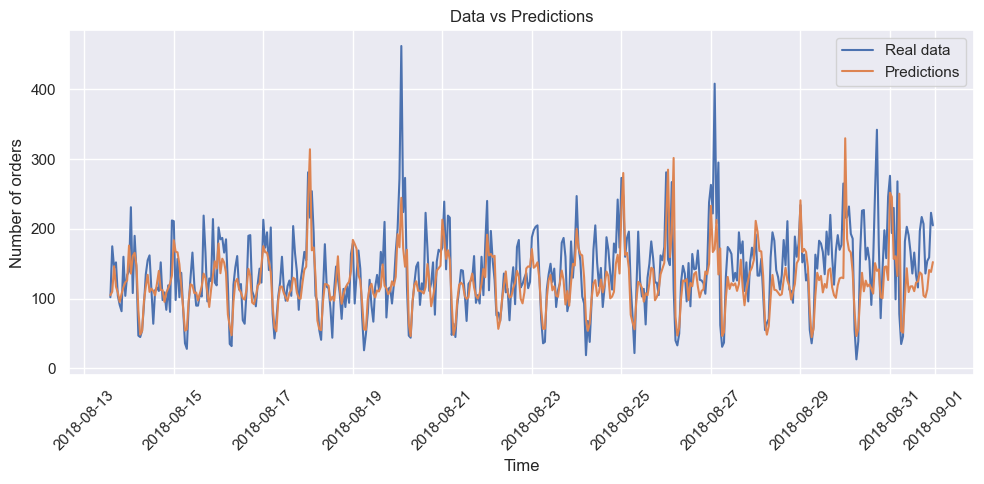

In [59]:
# Computing predictions
predictions_test = final_grid.best_estimator_.predict(features_test)
predictions = pd.Series(
    predictions_test, index=target_test.index, name="num_orders_predicted"
)
predictions_comparison = pd.concat([target_test, predictions], axis=1)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=predictions_comparison,
    x=predictions_comparison.index,
    y="num_orders",
    label="Real data",
)
sns.lineplot(
    data=predictions_comparison,
    x=predictions_comparison.index,
    y="num_orders_predicted",
    label="Predictions",
)
plt.legend()
plt.xticks(rotation=45)
plt.ylabel("Number of orders")
plt.xlabel("Time")
plt.title("Data vs Predictions")
plt.tight_layout()
plt.show()

**Summary**

Testing showed that the chosen model indeed passes both quality and adequacy checks. 

# General conclusion

This study was devoted to developing of a time series forecasting model, where the data was the number of orders at the airport. During the analysis, we visualized and analyzed the data. The data was also prepared by creating additional features for machine learning. During the training of models, we were able to choose the optimal combinations of hyperparameters for each of the models under consideration, the best of which, according to the test value of the metric *RMSE*, turned out to be *CatBoostRegressor*. It was also additionally established that hours are a particularly important factor in predicting order values.